# Value at Risk (VaR)

VaR is statistical measure estimating the maximum expected loss on a portfolio or position over a set period (e.g. 1 day) with a chosen confidence level (e.g. 95%). In other words, what's the most I could lose over a given time horizon with X% probability (under normal market conditions).

### Key Components of VaR
- Potential loss: The estimated maximum amount or percentage that could be lost within the given timeframe
- Time horizon: The period over which the potential loss is measured (e.g., 1 day, 1 week)
- Confidence level: Expressed as a percentage (e.g., 95%, 99%), indicating the probability that losses will not exceed the VaR amount

E.g., a 1-day, 95% VaR of $2000 means there's a 95% chance they won't lose more than $2000 in a single day, but a 5% chance they could lose more.

### There are 3 ways to calculate VaR:
#### 1. Historical method

The historical method looks at past market data to estimate future risk. It takes the historical returns of an asset or portfolio over a given period, such as the last 250 trading days, and ranks them from worst to best. The VaR is then set at the percentile corresponding to the chosen confidence level. 

This method is simple and doesn't assume a normal distribution, but it relies on past data, which may not capture extreme events.

#### 2. Variance-Covariance method

The variance-covariance method assumes that returns are normally distributed and estimates risk using mean, standard deviation, as well as the z-score corresponding to the chosen confidence level.

One of the main advantages of this method is its simplicity and efficiency, particularly for portfolios with multiple assets. However, its accuracy depends on the assumption that potential returns are normally distributed, which may not always hold, especially during extreme market conditions. 

#### 3. Monte Carlo Simulation

Monte Carlo simulations generate thousands of hypothetical market scenarios based on random price movements. It models different potential outcomes by simulating how prices might evolve based on past volatility and correlations. The resulting dataset is then analysed to determine the percentile-based VaR estimate. 

This method is more flexible and can handle complex portfolios but it requires strong assumptions about price behaviour. 

### How Traders Might Use VaR:

One of the most practical applications of VaR is in position sizing. A trader managing a $500,000 portfolio might have a risk tolerance of 1% per trade, meaning they are comfortable with a potential $5000 loss per trade. By calculating VaR, they can access whether a given trade aligns with this limit and adjust the position size accordingly. 

Hedge funds, proprietary trading firms, and institutional investors use VaR to allocate capital efficiently. If two trades have the same expected returns but one has a higher VaR, a trader may adjust exposure to avoid exceeding risk limits. Large institutions also use portfolio-wide VaR to monitor overall exposure and access whether they need to hedge positions.

Another use is stress testing. Traders often compare historical VaR to actual market moves, especially during volatile periods, to gauge whether their risk model holds up. If markets experience larger-than-expected losses, traders may refine their approach by incorporating additional risk measures like Conditional VaR or adjusting exposure to tail risks. 

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

import yfinance as yf

In [62]:
# import NVDA stock data from 1 Jan 2024 - 30 Nov 2025

start_date = "2024-01-01"
end_date = "2025-11-30"
ticker = "NVDA"

nvda = yf.download(ticker, start_date, end_date, auto_adjust = False)
nvda.tail(5)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2025-11-21,178.870041,178.880005,184.559998,172.929993,181.240005,346926200
2025-11-24,182.539841,182.550003,183.500000,176.479996,179.490005,256618300
2025-11-25,177.810104,177.820007,178.160004,169.550003,174.910004,320600300
2025-11-26,180.249954,180.259995,182.910004,178.240005,181.630005,183852000
2025-11-28,176.990143,177.000000,179.289993,176.500000,179.009995,121332800


## Historical method

In [63]:
# simple returns
nvda["Return"] = nvda["Adj Close"].pct_change().dropna()

In [64]:
# compute the historical VaR at 95% confidence level
confidence_level = 0.95
percentile = 1 - confidence_level

historical_VaR = nvda["Return"].quantile(percentile)

print(f"Historical Daily VaR (95% confidence): {historical_VaR:.4%}")

Historical Daily VaR (95% confidence): -4.7387%


If we want to compute VaR for NVDA over the next 6 months (~126 trading days), we can come up with a reasonable approximation using time scaling. 

In [65]:
days = 126

VaR_6M_scaled = historical_VaR * np.sqrt(days)

print(f"6-month VaR (95% confidence, scaled): {VaR_6M_scaled:.4%}")
# This can be interpreted as over the next 6 months, with confidence level of 95%, losses are not 
# expected to exceed 53.1916%

6-month VaR (95% confidence, scaled): -53.1916%


Standard time scaling of VaR typically underestimates true risk. 

The method below is another way to compute 6-month VaR without time scaling. 

In [66]:
# compute real realized return of NVDA over every past 6-month window (~ 126 trading days), 
# i.e. actual 6-month historical return

nvda["6M_Return"] = np.log(nvda["Adj Close"] / nvda["Adj Close"].shift(126))

In [67]:
Historical_6M_VaR = nvda["6M_Return"].quantile(0.05)

print(f"6-month VaR (95% confidence, using actual 6-month historical return to compute): {Historical_6M_VaR:.4%}")
# This can be interpreted as over the next 6 months, we are 95% confident that 
# NVDA won't lose more than 18.8053%

6-month VaR (95% confidence, using actual 6-month historical return to compute): -18.8053%


## Variance-Covariance method


In [ ]:
# compute mean and standard deviation of daily returns
mean_return = nvda["Return"].mean()
std_dev_return = nvda["Return"].std()

# compute VaR at 95% confidence level using the z-score
z_score = norm.ppf(1-confidence_level)
VaR_variance_covariance = mean_return + z_score * std_dev_return

print(f"Variance-Covariance Daily VaR (95% confidence): {VaR_variance_covariance: .4%}")

Variance-Covariance Daily VaR (95% confidence): -5.0499%


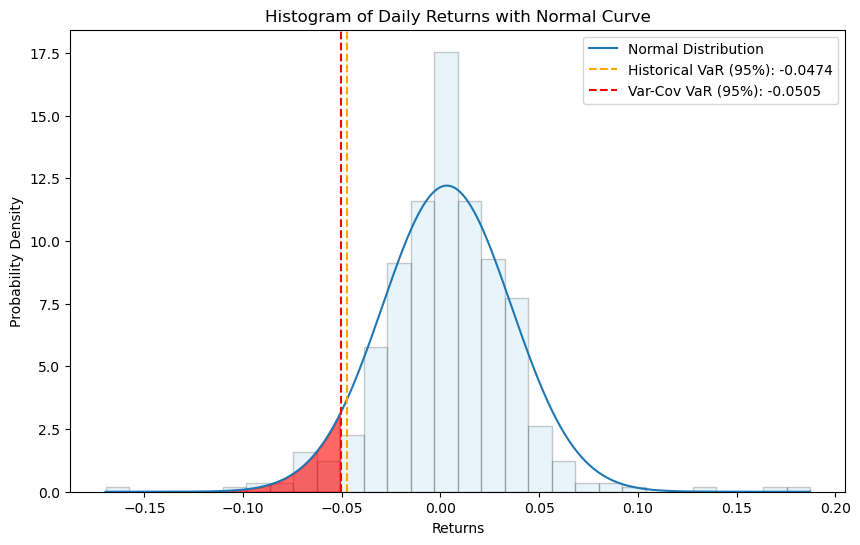

In [100]:
plt.figure(figsize = (10, 6))

count, bins, _ = plt.hist(nvda["Return"], bins = 30, density = True, alpha = 0.2, color = "skyblue",
                          edgecolor = "black")
x = np.linspace(bins.min(), bins.max(), 500)
y = norm.pdf(x, mean_return, std_dev_return)
plt.plot(x, y, label = "Normal Distribution")

plt.axvline(historical_VaR, color = "orange", linestyle = "--", 
            label = f"Historical VaR (95%): {historical_VaR:.4f}")
plt.axvline(VaR_variance_covariance, color = "red", linestyle = "--", 
            label = f"Var-Cov VaR (95%): {VaR_variance_covariance:.4f}")
plt.fill_between(x, 0, y, where = (x <= VaR_variance_covariance), color = "red", alpha = 0.6)

plt.xlabel("Returns")
plt.ylabel("Probability Density")
plt.title("Histogram of Daily Returns with Normal Curve")
plt.legend()
plt.show()
